# Funciones extra

In [39]:
# Plot polynomials

def plotPoly(polys, name, L, R):
    x = var('x')
    a = plot([],figsize=(8, 8),title=name)
    classic_colors = ['crimson', 'blue', 'green', 'orange', 'purple', 'brown', 'red', 'yellow']
    n = len(polys)
    assert(n > 0)
    assert(len(L) == n and len(R) == n)
    for i in range(n):
        a += plot(polys[i], x, L[i], R[i], color='gray')
    show(a)

In [3]:
# Parse polynomial with coefficients

def parsePoly(poly):
    var('x')
    ans = 0
    mono = 1;
    for i in range(len(poly.list())):
        ans += poly.list()[i] * mono
        mono *= x
    return ans

In [4]:
# Plot polynomials with interpolation method "interpolation"

def plotPolylines(groups, name, interpolation):
    polynomials = []
    L = []
    R = []
    for points in groups:
        p = parsePoly(interpolation(points))
        polynomials.append(p)
        minimum = points[0][0]
        maximum = points[0][0]
        for i in range(1, len(points)):
            if points[i][0] < minimum: minimum = points[i][0]
            if points[i][0] > maximum: maximum = points[i][0]
        L.append(minimum)
        R.append(maximum)
    plotPoly(polynomials, name, L, R)

In [5]:
from sage.misc.lazy_format import LazyFormat

def printPolynomials(polys):
    for p in polys:
        print(p[0])
        print(LazyFormat("L = %d") % p[1])
        print(LazyFormat("R = %d") % p[2])

In [6]:
def plotSpline(polys, name):
    polynomials = []
    L = []
    R = []
    for p in polys:
        polynomials.append(p[0])
        L.append(p[1])
        R.append(p[2])
    plotPoly(polynomials, name, L, R)

In [7]:
def Gaussian(a, b):
    n = len(a)
    assert(n > 1)
    m = len(a[0])
    assert(m > 1)
    assert(len(b) == n)
    EPS = 1e-15
    ans = [None for _ in range(m)]
    where = [-1 for _ in range(m)]
    row = 0
    col = 0
    while(row < n and col < m):
        sel = row
        for i in range(row, n):
            if abs(a[i][col]) > abs(a[sel][col]):
                sel = i
        if abs(a[sel][col]) < EPS:
            continue
        for i in range(col, m):
            a[sel][i], a[row][i] = a[row][i], a[sel][i]
        b[sel], b[row] = b[row], b[sel]
        where[col] = row
        for i in range(n):
            if i == row: continue
            c = a[i][col] / a[row][col]
            for j in range(col, m):
                a[i][j] -= a[row][j] * c
            b[i] -= b[row] * c
        row += 1
        col += 1
    for i in range(m):
        if where[i] == -1: continue
        ans[i] = b[where[i]] / a[where[i]][i]
    for i in range(n):
        s = 0
        for j in range(m):
            s += a[i][j] * ans[j]
        if abs(s - b[i]) > EPS:
            for k in range(m):
                ans[k] = None
            return ans
    return ans

In [8]:
def CubicSplineNatural(points):
    n = int(len(points)) - 1
    assert(n > 0)
    h = [ points[i+1][0] - points[i][0] for i in range(n)]
    beta = [ (points[i+1][1] - points[i][1]) / h[i] for i in range(n) ]
    v = [ (None if i == 0 else 6 * (beta[i] - beta[i - 1])) for i in range(n)]
    a = [ [0 for _ in range(n - 1)] for _ in range(n - 1) ]
    b = [ None for _ in range(n - 1)]
    a[0][0] = 2 * (h[0] + h[1])
    a[0][1] = h[1]
    for i in range(1, n - 2):
        a[i][i] = 2 * (h[i] + h[i+1])
        a[i][i-1] = h[i]
        a[i][i+1] = h[i+1]
    a[n-2][n-3] = h[n-2]
    a[n-2][n-2] = 2 * (h[n-2] + h[n-1])
    for i in range(n - 1):
        b[i] = v[i+1]
    lamb = Gaussian(a, b) # Solve Linear System Ax = b
    lambdas = [None for _ in range(n + 1)]
    lambdas[0] = 0
    lambdas[n] = 0
    for i in range(1, n):
        lambdas[i] = lamb[i-1]
    A = [points[i][1] for i in range(n)]
    B = [ (beta[i] - h[i] * (2 * lambdas[i] + lambdas[i+1]) / 6) for i in range(n)]
    C = [lambdas[i] / 2 for i in range(n)]
    D = [(lambdas[i+1] - lambdas[i]) / 6 / h[i] for i in range(n)]
    polynomials = []
    var('x')
    for i in range(n):
        cur = A[i] + B[i] * (x - points[i][0]) + C[i] * (x - points[i][0]) ** 2 + D[i] * (x - points[i][0]) ** 3
        polynomials.append([cur, points[i][0], points[i+1][0]])
    return polynomials # Returns polynomials with left and right limits for X

In [9]:
def Hermite(points): # (x, y, y', y'', ..., y^(k_i))
    #x = R.0
    n = len(points)
    sumk = 0
    for p in points:
        sumk += len(p) - 1
    assert(sumk > 1)
    memo = matrix(QQ, sumk, sumk, 0)
    vis = matrix(ZZ, sumk, sumk, 0)
    pos = 0
    X = []
    for p in points:
        k = len(p) - 1
        r = pos + k # x_i -> pos + 0, pos+1, pos+2, ..., pos + k - 1, Ya no es X_i -> (pos + k)
        for i in range(k):
            X.append(p[0])
        for i in range(pos, r):
            for l in range(r - i): # i -> pos + k - 1 = [i, r) -> l in [0, r-i)
                memo[i, l] = p[l+1] / factorial(l) # (l = 1 -> y, l = 2 -> y', l = 3 -> y'' ...)
                vis[i, l] = 1
        pos += k
    for l in range(1, sumk):
        for i in range(0, sumk - l):
            if vis[i, l] == 1: continue
            vis[i, l] = 1
            memo[i, l] = (memo[i+1][l-1] - memo[i][l-1]) / (X[i+l] - X[i])
    ans = 0
    prefix = 1
    for i in range(sumk):
        ans += memo[0][i] * prefix
        if i + 1 < sumk: prefix *= (x - X[i]) # (ax + b) * (cx + d) -> (ax + b) * (cx + d)
    return ans

# Problema 6

239/8
12261/26624


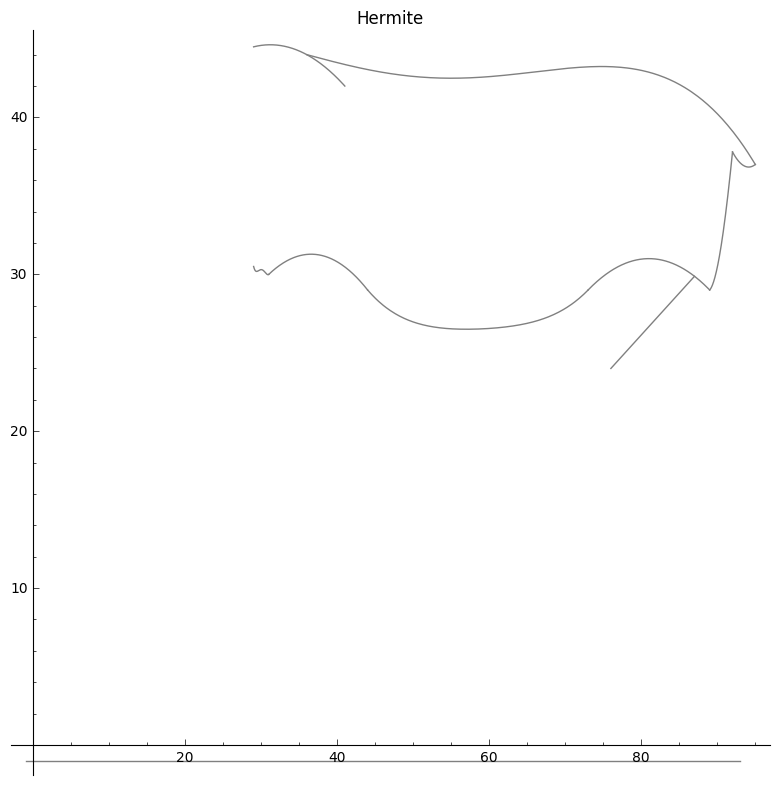

In [105]:
ux = 1
uy = 1

torso = [(36 * ux, 44 * uy), (55 * ux, 42.5 * uy, 0), (80 * ux, 43 * uy), (95 * ux, 37 * uy)]

cola = [(92 * ux, 37.8 * uy), (92.5 * ux, 37.4 * uy), (95 * ux, 37 * uy)]

cuello = [(29 * ux, 44.5 * uy), (36 * ux, 44 * uy), (41 * ux, 42 * uy)]

pierna_trasera = [(89 * ux, 29 * uy), (90.5 * ux, 31.8 * uy), (91 * ux, 33.5 * uy), (92 * ux, 37.8 * uy)]

pie_trasero11 = [(76 * ux, 24 * uy), (87 * ux, 239/8 * uy)]

panza1 = [(73 * ux, 29 * uy), (85 * ux, 30.5 * uy), (89 * ux, 29 * uy)]

panza2 = [(44 * ux, 29 * uy), (57 * ux, 26.5 * uy, 0), (73 * ux, 29 * uy, 1 / 2)]

panza3 = [(31 * ux, 30 * uy),  (44 * ux, 29 * uy, -16357/26624)]

panza4 = [(29 * ux, 30.5 * uy), (30 * ux, 30.3 * uy, 0), (31 * ux, 30 * uy, 12261/26624)]

points = [torso, cuello, cola, pierna_trasera, panza1, panza2, panza3, panza4, pie_trasero11,[(-ux, -uy), (93 * ux, -uy)]]


F = parsePoly(Hermite(panza1))
print(F(87))

P1 = parsePoly(Hermite(panza3))
print(derivative(P1)(31 * ux))

plotPolylines(points, "Hermite", Hermite)

# Problema 15

# Problema 16